<h1 style="text-align:center">New York City Taxi Trip Duration</h1>

<h3 style="text-align:center">Load Libraries</h3>

In [11]:
import numpy as np
import pandas as pd

# Visualization
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from bokeh.plotting import figure, show 
from bokeh.charts import Donut, show
from bokeh.io import output_notebook
output_notebook()

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from xgboost import XGBRegressor
from xgboost import DMatrix
from xgboost import cv

from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from time import time

Loading BokehJS ...

In [2]:
# import sys
# sys.path.append("/holidays")
# import holidays
# from datetime import date

In [3]:
from IPython.core.display import HTML
HTML("""
<style>
.output_png {
    display: table-cell;
    text-align: center;
    vertical-align: middle;
}
</style>
""")

<h3 style="text-align:center">Load Dataset</h3>

In [4]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

In [5]:
print("Train set shape:", train_df.shape)
print("Test set shape:", test_df.shape)

Train set shape: (1458644, 11)
Test set shape: (625134, 9)


<h3 style="text-align:center">Data exploration</h3>

In [6]:
# Observation of the first 5 elements in the training set
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [7]:
test_df.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [8]:
# Check the types or each features
train_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Analyze missing data 

In [9]:
# print(train_df.isnull().sum(), "\n")
# print(test_df.isnull().sum())

pd.DataFrame( {'missing values(train set)': train_df.isnull().sum(),
              'missing values(test_set)' : test_df.isnull().sum() } )

,missing values(test_set),missing values(train set)
dropoff_datetime,NaN,0
dropoff_latitude,0.0,0
dropoff_longitude,0.0,0
id,0.0,0
passenger_count,0.0,0
pickup_datetime,0.0,0
pickup_latitude,0.0,0
pickup_longitude,0.0,0
store_and_fwd_flag,0.0,0
trip_duration,NaN,0


There's no missing data in both the train and test dataframe

<u>Target Feature</u>

In [10]:
# pd.options.display.float_format = '{:,.2f}'.format
train_df['trip_duration'].describe()

count    1.458644e+06
mean     9.594923e+02
std      5.237432e+03
min      1.000000e+00
25%      3.970000e+02
50%      6.620000e+02
75%      1.075000e+03
max      3.526282e+06
Name: trip_duration, dtype: float64

Let's observe the skewness of the trip duration

In [11]:
train_df['trip_duration'].skew()

343.1639435917362

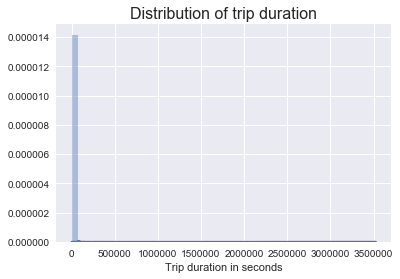

In [12]:
sns.distplot(train_df['trip_duration'])
plt.title("Distribution of trip duration", size=16)
plt.xlabel("Trip duration in seconds")
plt.show()

In regression problems, it is important to look for the skewness of the target feature. <br>
In fact, algorithms such as linear regression or K-Nearest Neighbors are sensitive to the skewness of the data. <br>
The most common correction for a positive skew is to apply <i>the Log transform</i> to have a normally distributed variable.

Skew is: -0.340704230448


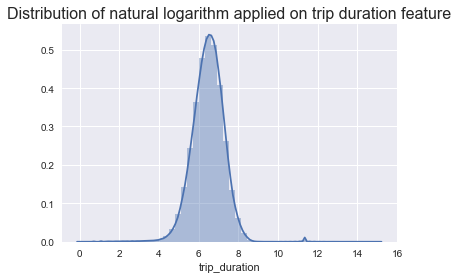

In [13]:
target = np.log(train_df['trip_duration'])
print("Skew is:", target.skew())
sns.distplot(target)
plt.title("Distribution of natural logarithm applied on trip duration feature", size=16)
plt.show()

For the sake of meaningful visualization, we store the result in another variable so that we will be able to make use of it during the processing part.

<u>Correlation with trip duration</u>

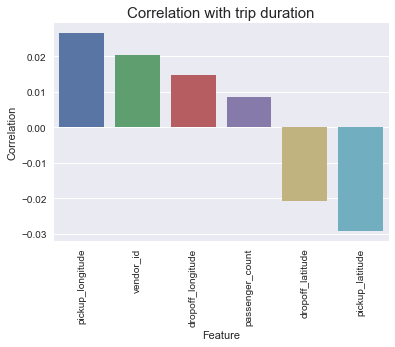

In [14]:
corr = train_df.drop(['id'], axis=1).corr()
corr_df = pd.DataFrame(corr['trip_duration'].sort_values(ascending=False))[1:]
corr_df.columns = ['Correlation']
corr_df.index.name = 'Feature'

ax = sns.barplot(x=corr_df.index, y='Correlation', data=corr_df)
ax.set(ylabel='Correlation')
plt.xticks(rotation=90)
plt.title('Correlation with trip duration', size=15)
plt.show()

We observe that there is not strong relation with the trip duration and the actual numerical features. <br>
We need to feature engineering the string features to establish a new correlation plot as we might infer something more interesting.

<h3 style="text-align:center">Data Cleaning</h3>

In [15]:
pd.DataFrame( {'passenger_count (train set)': train_df['passenger_count'].value_counts(),
              'passenger_count (test_set)' : test_df['passenger_count'].value_counts()} )

,passenger_count (test_set),passenger_count (train set)
0,23.0,60
1,443447.0,1033540
2,90027.0,210318
3,25686.0,59896
4,12017.0,28404
5,33411.0,78088
6,20521.0,48333
7,NaN,3
8,NaN,1
9,2.0,1


We will treat values with 0 passenger_count to 1. <br>

In [16]:
def clean_passenger_count(dataset):
    dataset.loc[ dataset['passenger_count'] == 0, 'passenger_count' ] = 1

clean_passenger_count(train_df)
clean_passenger_count(test_df)

In [17]:
train_df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

In [18]:
# Pie chart with Bokeh
pie_chart = Donut(train_df['passenger_count'].value_counts())
show(pie_chart)

<u>Trip duration</u>

In [19]:
train_df.loc[ train_df['trip_duration'] > 80000, : ].shape

(1899, 11)

About 1900 trips accounted a trip duration of about 80000s, which is nearly 1 day! <br>

In [20]:
train_df.loc[ train_df['trip_duration'] > 70000, : ].head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
531,id3307903,2,2016-02-20 04:03:06,2016-02-21 03:33:00,3,-74.008102,40.741489,-74.009956,40.714611,N,84594
1134,id1091477,2,2016-05-07 18:36:22,2016-05-08 18:32:11,1,-73.990242,40.750919,-73.976280,40.750889,N,86149
1865,id3431345,2,2016-06-07 12:58:48,2016-06-08 12:58:00,6,-73.954956,40.777649,-73.981033,40.743713,N,86352
3442,id1487069,2,2016-02-13 00:21:49,2016-02-14 00:19:05,1,-73.968590,40.799217,-73.979584,40.784714,N,86236
4172,id3674870,2,2016-03-18 11:54:20,2016-03-19 11:34:17,1,-73.989090,40.736992,-73.972336,40.751511,N,85197


<h3 style="text-align:center">Feature Engineering</h3>

<u>Datetime</u>

In [21]:
# convert feature to datetime
train_df['pickup_datetime'] = pd.to_datetime(train_df['pickup_datetime'], \
                    format="%Y-%m-%d %H:%M:%S") 

# Extract weekday number (from Monday=0 to Sunday=6)
train_df['DayOfWeekNum'] = train_df['pickup_datetime'].dt.dayofweek

# Extract Month 
train_df['Month'] = train_df['pickup_datetime'].dt.month

# Extract the Month's day from 0 to 31
train_df['DayOfMonth'] = train_df['pickup_datetime'].dt.day

# Extract the Hour of the day
train_df['HourOfDay'] = train_df['pickup_datetime'].dt.hour




<u>Weekend</u>

In [22]:
# train_df['date'] = train_df['pickup_datetime'].dt.date

In [23]:
# train_df['weekend'] = np.zeros(train_df.shape[0]).astype(int) 

# train_df['weekend'] = train_df.loc[ train_df['DayOfWeekNum'] == 5 | \
#              train_df['DayOfWeekNum'] == 6, 'DayOfWeekNum'] = 1

# train_df.loc[ train_df['DayOfWeekNum'] >= 5, 'weekend'] = 1

In [24]:
def get_weekend(dataset):
    """ 
    Create a new column filled with 0.
    Add a 1 element if we are in weekend, i.e. Saturday or Sunday
    since DayOFWeekNum start at Monday=0, we are in weekend if the
    number is DayOfWeekNum >= 5.
    """
    dataset['weekend'] = np.zeros(dataset.shape[0]).astype(int)

    dataset.loc[ train_df['DayOfWeekNum'] >= 5, 'weekend'] = 1
    
get_weekend(train_df)
get_weekend(test_df)

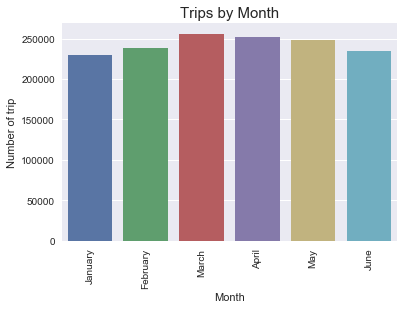

In [25]:
fig, ax = plt.subplots()

sns.countplot(x='Month', 
             data=train_df)

labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['January', 'February', 'March', 'April', 'May', 'June']

ax.set_xticklabels(labels)

plt.xticks(rotation=90)
plt.title('Trips by Month', size=15)
plt.ylabel('Number of trip')

plt.show()

Interestingly, the data provided only offers the trips of the first half of 2016. <br>
Furthermore, we observe that March was the most successful month in terms of number of trips. <br>
On the other hand January is not as successful, probably due to the fact that January is usually the coldest month of the year for New York.

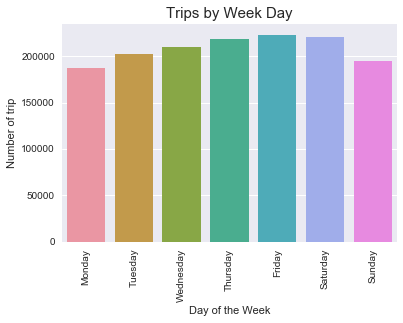

In [26]:
fig, ax = plt.subplots()

sns.countplot(x='DayOfWeekNum',
              data=train_df)
labels = [item.get_text() for item in ax.get_xticklabels()]
labels = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', \
         'Friday', 'Saturday', 'Sunday']

ax.set_xticklabels(labels)

plt.xticks(rotation=90)
plt.title('Trips by Week Day', size=15)
plt.xlabel('Day of the Week')
plt.ylabel('Number of trip')


plt.show()

This previous plot display how the traffic of taxis is doing during the weeks. <br>
Friday seems to be the most profitable day with Saturday while Sunday and Monday are the less demanding of taxis.

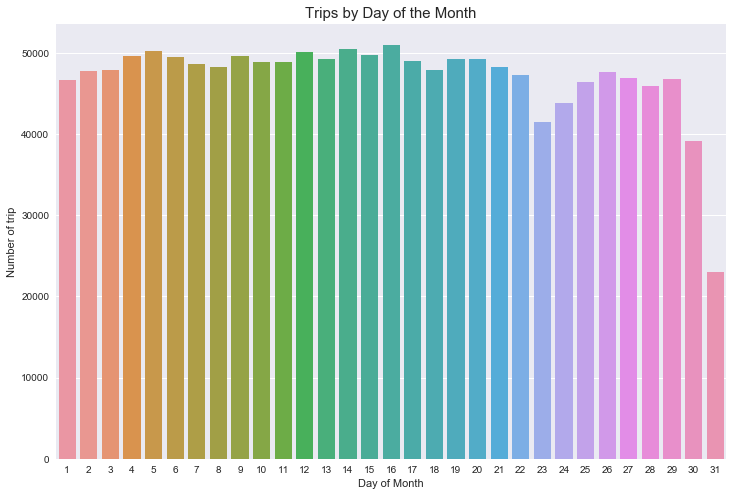

In [27]:
plt.figure(figsize=(12,8))

sns.countplot(x='DayOfMonth',
             data=train_df)

plt.title('Trips by Day of the Month', size=15)
plt.xlabel('Day of Month')
plt.ylabel('Number of trip')

plt.show()

The repartition is quite well distributed. <br>
One might notice that the 31st there is way less trips but that is due to the fact there is way less 31st number in the year. <br>
In 2016, only January, March and May had 31 days in the first half of the year. <br>
Days with 31 days also include day 30 so end of months are quite low regarding number of trips from taxis comparing to other days.

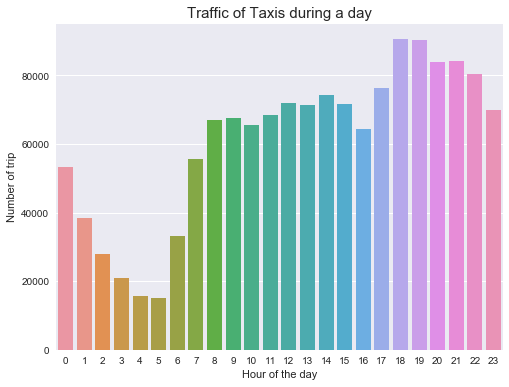

In [28]:
plt.figure(figsize=(8,6))

sns.countplot(x='HourOfDay',
           data=train_df)

plt.title('Traffic of Taxis during a day', size=15)
plt.xlabel('Hour of the day')
plt.ylabel('Number of trip')

plt.show()

Clearly from this plot we can infer that peak times are [6pm : 7pm] and off-peak times are [4am : 5pm].
From 6am the trend is growing up to 7pm. And past this hour, the trend is going the other way.

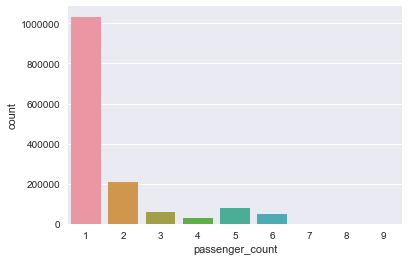

In [29]:
sns.countplot(train_df['passenger_count'])

<u>Passenger count</u>

In [30]:
train_df['passenger_count'].value_counts()

1    1033600
2     210318
5      78088
3      59896
6      48333
4      28404
7          3
9          1
8          1
Name: passenger_count, dtype: int64

We will group the number of passenger to be less sparse.

In [31]:
def transform_passenger_count(dataset):
    dataset.loc[ dataset['passenger_count'] >= 3, 'passenger_count' ] = 3
    
transform_passenger_count(train_df)
transform_passenger_count(test_df)

# train_df.loc[ train_df['passenger_count'] >= 3, 'passenger_count' ] = 3

In [32]:
# Pie chart with Bokeh
pie_chart = Donut(train_df['passenger_count'].value_counts())
show(pie_chart)

<u>PCA on longitude and latitude coordinates</u>

We use PCA to transform longitude and latitude coordinates. In this case it is not about dimension reduction since we transform 2D-> 2D. The rotation could help for decision tree splits.

In [34]:
coords = np.vstack( (train_df[['pickup_latitude', 'pickup_longitude']].values,
                     test_df[['pickup_latitude', 'pickup_longitude']].values ) )

pca = PCA().fit(coords)

train_df['pickup_pca0'] = pca.transform(train_df[['pickup_latitude', 
                                           'pickup_longitude']])[:, 0]

train_df['pickup_pca1'] = pca.transform(train_df[['pickup_latitude',
                                            'pickup_longitude']])[:, 1]

test_df['pickup_pca0'] = pca.transform(test_df[['pickup_latitude', 
                                           'pickup_longitude']])[:, 0]

test_df['pickup_pca1'] = pca.transform(test_df[['pickup_latitude',
                                            'pickup_longitude']])[:, 1]


<u>Clustering</u>

In [36]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])


In [37]:
train_df['pickup_cluster'] = kmeans.predict(train_df[['pickup_latitude', \
                                                   'pickup_longitude']])
test_df['pickup_cluster']  = kmeans.predict(test_df[['pickup_latitude', \
                                                    'pickup_longitude']])

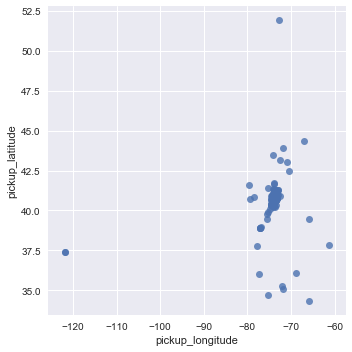

In [38]:
sns.lmplot(x='pickup_longitude', 
           y='pickup_latitude',
           fit_reg=False,
#            hue='pickup_cluster',
          data=train_df)
plt.show()

<u>Distance in miles</u>

In [39]:
train_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,DayOfWeekNum,Month,DayOfMonth,HourOfDay,weekend,pickup_pca0,pickup_pca1,pickup_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,0,3,14,17,0,0.008300,0.017177,68
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,6,6,12,0,1,0.007128,-0.012224,86
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,1,1,19,11,0,0.005250,0.013120,68
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2,4,6,19,0,0.037106,-0.030242,50
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,5,3,26,13,1,-0.001287,0.042269,16


In [40]:
from geopy.distance import great_circle

def distance_calc(row):
    pickup  = (row['pickup_latitude'], row['pickup_longitude'])
    dropoff = (row['dropoff_latitude'], row['dropoff_longitude'])
    
    return great_circle(pickup, dropoff).km

def get_distance(dataset):
    dataset['distance'] = dataset.apply(lambda row: distance_calc(row), axis=1)
    dataset.drop(['pickup_latitude', 'pickup_longitude', \
                  'dropoff_latitude','dropoff_longitude'], 
                   axis=1,
                   inplace=True)
    
# train_df['distance'] = train_df.apply(lambda row: distance_calc(row), axis=1)


# Note : Quite long to compute 
get_distance(train_df)
get_distance(test_df)

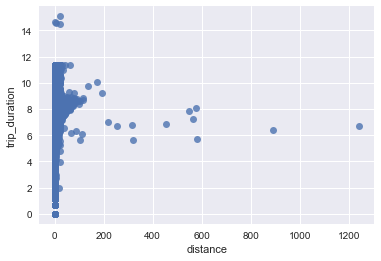

In [41]:
target = np.log(train_df['trip_duration'])
sns.regplot(x='distance', y=target, data=train_df,
           fit_reg=False)


The plot did not satisfy our expectation of a regression line due to the outliers.<br>
First we will need to remove them

In [42]:
print(train_df.shape, target.shape)

(1458644, 16) (1458644,)


In [43]:
train_df = train_df[ train_df['distance'] < 100 ]

# target and train_df should be same dimension so we should carefully delete the outlier in the y-axis
target = np.log(train_df['trip_duration'])
target = pd.DataFrame(target)
outliers = target[target['trip_duration'] > 12].index.tolist()
train_df.drop(outliers, inplace=True)
target.drop(outliers, inplace=True)

In [44]:
train_df.shape

(1458621, 16)

In [45]:
target.shape

(1458621, 1)

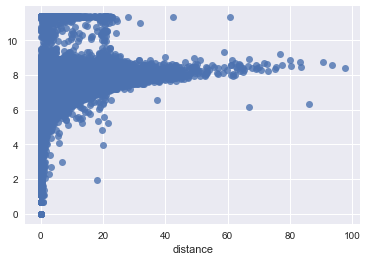

In [46]:
sns.regplot(x='distance', y=target, data=train_df,
           fit_reg=False)

Let's look at what the regression line might look like (via fit_reg in seaborn)

In [47]:
# sns.regplot(x='distance', y=target, data=train_df,
#            fit_reg=True)

The regression fail to predict a lot of values. <br>
We will look if applying a function to the distance will end up with a better regression line.

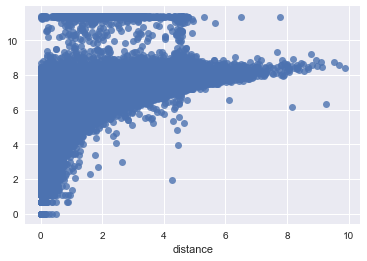

In [48]:
# target = np.log(train_df['trip_duration'])
dist_log = np.sqrt(train_df['distance'])
sns.regplot(x=dist_log, y=target, data=train_df,
           fit_reg=False)

The sqrt function seems to be a better choice. <br>
We will use that function and apply it to the distance feature.

In [49]:
# Transform distance feature
def transform_distance(dataset):
    dataset['sqrt_distance'] = np.sqrt(dataset['distance'])    
    dataset.drop(['distance'], axis=1, inplace=True)

transform_distance(train_df)
transform_distance(test_df)


In [50]:
# target = np.log(train_df['trip_duration'])
# dist_log = np.sqrt(train_df['distance'])
# sns.regplot(x=dist_log, y=target, data=train_df,
#            fit_reg=True)

<u>Datetime</u>

In the same way when we try to get information out off the pickup_datetime feature, we will extend this to the dropoff datetime and apply the same transformation to the test set.

In [51]:
train_df.drop(['dropoff_datetime','DayOfWeekNum', 'Month', 'DayOfMonth', 'HourOfDay'], axis=1, inplace=True)

In [52]:
def transform_datetime(dataset):
    # convert column to datetime type
    dataset['pickup_datetime'] = pd.to_datetime(dataset['pickup_datetime'], \
                    format="%Y-%m-%d %H:%M:%S")
    
    # Extract weekday number (from Monday=0 to Sunday=6)
    dataset['Pickup_NumDayWeek'] = dataset['pickup_datetime'].dt.dayofweek
    
    # Extract Month 
    dataset['Month'] = dataset['pickup_datetime'].dt.month
    
    # Extract the Month's pickup day from 0 to 31
    dataset['Pickup_Day'] = dataset['pickup_datetime'].dt.day
        
    # Extract the dataset Hour/Minute
    dataset['Pickup_Hour'] = dataset['pickup_datetime'].dt.hour
    dataset['Pickup_Minute'] = dataset['pickup_datetime'].dt.minute
#     dataset['Pickup_Second'] = dataset['pickup_datetime'].dt.second
    
    # Extract the week number of the year
    dataset['Pickup_NumWeekYear'] = dataset['pickup_datetime'].dt.weekofyear
    
    
    dataset = dataset.drop( ['pickup_datetime'], axis=1, inplace=True )
    
transform_datetime(train_df)
transform_datetime(test_df)

In [53]:
test_df.columns

Index(['id', 'vendor_id', 'passenger_count', 'store_and_fwd_flag', 'weekend',
       'pickup_pca0', 'pickup_pca1', 'pickup_cluster', 'sqrt_distance',
       'Pickup_NumDayWeek', 'Month', 'Pickup_Day', 'Pickup_Hour',
       'Pickup_Minute', 'Pickup_NumWeekYear'],
      dtype='object')

In [54]:
train_df.head()

,id,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,weekend,pickup_pca0,pickup_pca1,pickup_cluster,sqrt_distance,Pickup_NumDayWeek,Month,Pickup_Day,Pickup_Hour,Pickup_Minute,Pickup_NumWeekYear
0,id2875421,2,1,N,455,0,0.008300,0.017177,68,1.224313,0,3,14,17,24,11
1,id2377394,1,1,N,663,1,0.007128,-0.012224,86,1.343881,6,6,12,0,43,23
2,id3858529,2,1,N,2124,0,0.005250,0.013120,68,2.527231,1,1,19,11,35,3
3,id3504673,2,1,N,429,0,0.037106,-0.030242,50,1.218982,2,4,6,19,32,14
4,id2181028,2,1,N,435,1,-0.001287,0.042269,16,1.090378,5,3,26,13,30,12


<u>store_and_fwd_flag</u>

In [55]:
train_df['store_and_fwd_flag'].value_counts()

N    1450576
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [56]:
test_df['store_and_fwd_flag'].value_counts()

N    621704
Y      3430
Name: store_and_fwd_flag, dtype: int64

In [57]:
def transform_store_and_fwd_flag(dataset):
    dataset['store_and_fwd_flag'] = dataset['store_and_fwd_flag'].map( {'Y': 1, 'N': 0} ).astype(int)

transform_store_and_fwd_flag(train_df)
transform_store_and_fwd_flag(test_df)

In [58]:
train_df.head()

,id,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,weekend,pickup_pca0,pickup_pca1,pickup_cluster,sqrt_distance,Pickup_NumDayWeek,Month,Pickup_Day,Pickup_Hour,Pickup_Minute,Pickup_NumWeekYear
0,id2875421,2,1,0,455,0,0.008300,0.017177,68,1.224313,0,3,14,17,24,11
1,id2377394,1,1,0,663,1,0.007128,-0.012224,86,1.343881,6,6,12,0,43,23
2,id3858529,2,1,0,2124,0,0.005250,0.013120,68,2.527231,1,1,19,11,35,3
3,id3504673,2,1,0,429,0,0.037106,-0.030242,50,1.218982,2,4,6,19,32,14
4,id2181028,2,1,0,435,1,-0.001287,0.042269,16,1.090378,5,3,26,13,30,12


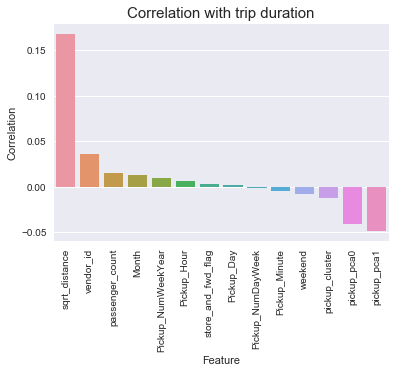

In [59]:
corr = train_df.drop(['id'], axis=1).corr()
corr_df = pd.DataFrame(corr['trip_duration'].sort_values(ascending=False))[1:]
corr_df.columns = ['Correlation']
corr_df.index.name = 'Feature'

ax = sns.barplot(x=corr_df.index, y='Correlation', data=corr_df)
ax.set(ylabel='Correlation')
plt.xticks(rotation=90)
plt.title('Correlation with trip duration', size=15)
plt.show()

In [60]:
corr['trip_duration']

vendor_id             0.035805
passenger_count       0.015450
store_and_fwd_flag    0.003006
trip_duration         1.000000
weekend              -0.007953
pickup_pca0          -0.040434
pickup_pca1          -0.048932
pickup_cluster       -0.012179
sqrt_distance         0.168385
Pickup_NumDayWeek    -0.001413
Month                 0.013354
Pickup_Day            0.002353
Pickup_Hour           0.005969
Pickup_Minute        -0.004108
Pickup_NumWeekYear    0.010198
Name: trip_duration, dtype: float64

<h3 style="text-align:center">Saving train and test set (checkpoint)</h3>

In [61]:
a

NameError: name 'a' is not defined

<u>Saving</u>

In [ ]:
# Saving into pickle file
train_df.to_pickle('train_df.p')
test_df.to_pickle('test_df.p')

target.to_pickle('target.p')

<u>Loading</u>

In [3]:
# Loading the pickle file, analysis can start here and we don't have to process the previous code each time we come back
train_df = pd.read_pickle('train_df.p')
test_df = pd.read_pickle('test_df.p')
target  = pd.read_pickle('target.p')

In [4]:
train_df.head()

,id,vendor_id,passenger_count,store_and_fwd_flag,trip_duration,weekend,pickup_pca0,pickup_pca1,pickup_cluster,sqrt_distance,Pickup_NumDayWeek,Month,Pickup_Day,Pickup_Hour,Pickup_Minute,Pickup_NumWeekYear
0,id2875421,2,1,0,455,0,0.008300,0.017177,67,1.224313,0,3,14,17,24,11
1,id2377394,1,1,0,663,1,0.007128,-0.012224,49,1.343881,6,6,12,0,43,23
2,id3858529,2,1,0,2124,0,0.005250,0.013120,26,2.527231,1,1,19,11,35,3
3,id3504673,2,1,0,429,0,0.037106,-0.030242,94,1.218982,2,4,6,19,32,14
4,id2181028,2,1,0,435,1,-0.001287,0.042269,84,1.090378,5,3,26,13,30,12


In [5]:
test_df.head()

,id,vendor_id,passenger_count,store_and_fwd_flag,weekend,pickup_pca0,pickup_pca1,pickup_cluster,sqrt_distance,Pickup_NumDayWeek,Month,Pickup_Day,Pickup_Hour,Pickup_Minute,Pickup_NumWeekYear
0,id3004672,1,1,0,0,0.014966,-0.018609,5,1.657468,3,6,30,23,59,26
1,id3505355,1,1,0,1,-0.007952,-0.071097,91,1.661330,3,6,30,23,59,26
2,id1217141,1,1,0,0,0.024165,-0.012876,30,1.143033,3,6,30,23,59,26
3,id2150126,2,1,0,0,-0.017856,0.020637,98,2.295773,3,6,30,23,59,26
4,id1598245,1,1,0,1,-0.003513,0.010486,1,0.980363,3,6,30,23,59,26


In [6]:
test_df.shape

(625134, 15)

In [7]:
train_df.shape

(1458621, 16)

<h3 style="text-align:center">Split-out dataset</h3>

In [ ]:
# # Using a subset for model training for comparing algorithms
# train_df = train_df.iloc[:int(train_df.shape[0] / 100)]
# target = target.iloc[:int(target.shape[0] / 100)]

In [8]:
# Test options and evaluation metric
num_folds = 10 
seed = 46
test_size = 0.20
scoring = 'r2'

In [9]:
X = train_df.drop(['id', 'trip_duration'], axis=1).values
Y = target.values.ravel()

X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=test_size,\
                                                   random_state=seed)


In [5]:
print(X_train.shape, y_train.shape, "\n", X_test.shape, y_test.shape)

(1166896, 14) (1166896,) 
 (291725, 14) (291725,)


<h3 style="text-align:center">Build Models</h3>

In [ ]:
# # Spot-Check Algorithms
# models = []
# models.append( ('LR', LinearRegression()) )
# models.append( ('LASSO', Lasso()) )
# models.append( ('RIDGE', Ridge()) )
# models.append( ('KNN', KNeighborsRegressor()) )
# models.append( ('CART', DecisionTreeRegressor()) )
# models.append(  ('SVR', SVR()))
# models.append( ('RF', RandomForestRegressor()) )
# models.append( ('GB', GradientBoostingRegressor()) )

# results = []
# names = []
# for name, model in models:
#     kfold = KFold(n_splits=num_folds, 
#                   random_state=seed)
#     cv_results = cross_val_score(model, X_train, 
#                                  y_train, 
#                                  cv=kfold, 
#                                  scoring=scoring)
#     results.append(cv_results)
#     names.append(name)
#     msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
#     print(msg)

In [ ]:
# # Compare algorithms
# fig = plt.figure()
# fig.suptitle('Algorithm Comparison')
# ax = fig.add_subplot(111)
# plt.boxplot(results)
# ax.set_xticklabels(names)
# plt.show()

From the plot, Gradient Boosting achieved good results compared to the other algorithms

<h3 style="text-align:center">Tuning Algorithm</h3>

Here we will use GridSearch to try a set of different numbers of the argument of gradient boosting in order to aim for better accuracy.
We will use the built-in function from xgboost to speed up the overall process and computation time.

In [6]:
XGBRegressor()

XGBRegressor(base_score=0.5, colsample_bylevel=1, colsample_bytree=1, gamma=0,
       learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='reg:linear', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=0, silent=True, subsample=1)

In [ ]:
start = time()
model = XGBRegressor(seed=seed, nthread=-1, max_depth=8, n_estimators=100)

subsample = [0.5, 0.75, 1.0]

param_grid = dict(subsample=subsample)
kfold = KFold(n_splits=num_folds, random_state=seed)
grid_search = GridSearchCV(model, param_grid, scoring=scoring, \
                           n_jobs=-1, cv=kfold)
grid_result = grid_search.fit(X_train, y_train)

# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_) )

print("elapsed time:", round( (time() - start), 2 ), "s")

<h3 style="text-align:center">Testing Model </h3>

In [ ]:
XGBRegressor()

In [ ]:
model = XGBRegressor(seed=seed, n_estimators=300, \
                                 nthread=-1, \
            
                                  max_depth=5)

model.fit(X_train, y_train)
pred = model.predict(X_test)


In [ ]:
pred.shape

In [ ]:
def rmsle(predicted,real):
    sum=0.0
    for x in range(len(predicted)):
        p = np.log(predicted[x]+1)
        r = np.log(real[x]+1)
        sum = sum + (p - r)**2
    return (sum/len(predicted))**0.5

In [ ]:
accuracy = rmsle(y_test, pred)
print(accuracy)

<h3 style="text-align:center">Finalize Model</h3>

In [ ]:
X_fin = test_df.drop(['id'], axis=1).values

In [ ]:
model = XGBRegressor(seed=seed, n_estimators=300, \
                                 nthread=-1, \
                                  max_depth=5)
model.fit(X_train, y_train)
pred = model.predict(X_fin)

print(pred)

In [ ]:
# transform the predictions (we applied log to skew the distribution )
# The function np.exp() will cancel the log
final_pred = np.exp(pred)

print(final_pred)

In [ ]:
final_pred.shape

<h3 style=text-align:center>Submit the results</h3>

In [ ]:
id = test_df['id'].values
data = { 'id': id, 'trip_duration': final_pred}
df = pd.DataFrame(data, columns=['id', 'trip_duration'])

Save to output file

In [ ]:
df.to_csv("result2.csv", index=False)